In [ ]:
%pip install h5py scipy hnswlib

: 

In [3]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import vecnn
import time
import hnswlib
import faiss
from typing import Any, Tuple

import h5py

DATA_PATH = '../../../sisap'


# import os
# print(os.path.isdir(DATA_PATH))

laion_path = f'{DATA_PATH}/laion2B-en-clip768v2-n=300K.h5'
laion_gold_queries_path = f'{DATA_PATH}/public-queries-2024-laion2B-en-clip768v2-n=10k.h5'
laion_gold_path = f'{DATA_PATH}/gold-standard-dbsize=300K--public-queries-2024-laion2B-en-clip768v2-n=10k.h5'

f = h5py.File(laion_path, 'r')
laion_data = np.array(f["emb"]).astype("float32") # shape: (300000, 768)

f = h5py.File(laion_gold_queries_path) 
laion_gold_queries = np.array(f["emb"]).astype("float32") # shape: (10000, 768)

f = h5py.File(laion_gold_path) 
laion_gold_dists = np.array(f["dists"]).astype("float32") # shape: (10000, 1000), seem to be sorted in ascending order
laion_gold_knns = np.array(f["knns"]).astype("uint64") # shape: (10000, 1000), same shape as dists.

In [9]:
dim = 128
num_elements = 100000

# Generating sample data
data = np.float32(np.random.random((num_elements, dim)))
ids = np.arange(num_elements)

p = hnswlib.Index(space = 'l2', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

# Element insertion (can be called several times):
p.add_items(data, ids)

# Controlling the recall by setting ef:
p.set_ef(50) # ef should always be > k


# Query dataset, k - number of the closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(data, k = 1)



In [62]:
# data = np.array([[0.0,0.0],[2.0,1.0],[3.0,2.0],[7.0,2.0],[1.0,5.0],[2.0,5.0], [2.0,6.0]]).astype("float32")
# q = np.array([3.0,5.0]).astype("float32")

n = 1000
dims = 600
data = np.random.random((n,dims)).astype("float32")


ds = Dataset(data)

start = time.time()
tree = VpTree(ds)
# print(tree.num_distance_calculations_in_build)
print("vp-tree build:", time.time()-start)

start = time.time()
hnsw = Hnsw(ds, HnswParams(0.6, 6, 3, 4))
# print(hnsw.num_distance_calculations_in_build)
print("hnsw build:", time.time()-start)

start = time.time()
pytree = cKDTree(data)
print("cKDTree build:", time.time()-start)

q = np.random.random((dims,)).astype("float32")
k = 100

start = time.time()
for i in range(1000):
    res = linear_knn(ds, q, k)
print("linear query:", time.time()-start)
print("linear", (res.indices, res.distances, res.num_distance_calculations))

start = time.time()
for i in range(1000):
    res =tree.knn(q, k)
print("vp-tree query:", time.time()-start)
print((res.indices, res.distances, res.num_distance_calculations) )

# print(tree.num_distance_calculations_in_build)
start = time.time()
for i in range(1000):
    res =hnsw.knn(q, k)
print("hnsw_query:", time.time()-start)
print("hnsw", (res.indices, res.distances, res.num_distance_calculations) )

start = time.time()
for i in range(1000):
    distances, indices = pytree.query(q, k=k, workers=8)
print("cKDTree query:", time.time()-start)
print("cKDTree", indices)




vp-tree build: 0.025766372680664062
hnsw build: 0.2100062370300293
cKDTree build: 0.0027379989624023438
linear query: 2.769984483718872
linear (array([948, 196, 364, 397, 783, 506, 117, 539,  91, 614, 241, 104, 526,
       630,  42, 232, 747, 627, 417, 704, 237, 629,  38, 216, 654, 229,
       200, 427, 651, 150, 167, 410, 315, 824, 318, 521, 628, 940, 609,
       400,  59, 468, 943, 394,  27, 251, 151, 762,  51, 555, 843, 169,
       210, 727, 495, 903, 854, 452, 511, 119, 307, 849, 786, 223,   8,
        69,  68, 608, 288, 588, 658, 790, 524, 862, 472, 832, 198, 430,
       558, 284, 454, 142, 445, 731, 160, 757, 326, 141, 899, 504, 501,
       668, 748, 166, 837, 482, 252, 577, 328, 218], dtype=uint64), array([92.21591 , 91.89738 , 92.56501 , 88.894714, 90.7033  , 90.48813 ,
       91.16161 , 89.9235  , 89.78356 , 88.54101 , 88.483215, 92.219215,
       92.248   , 89.17659 , 91.78638 , 92.785866, 92.46391 , 90.21917 ,
       86.39458 , 87.7415  , 88.94417 , 87.859085, 90.42553 , 92.

17679

In [12]:
linear_knn(ds, q, 3).indices

array([6, 5, 4], dtype=uint32)

In [ ]:
laion_gold_queries.shape

(10000, 768)

In [ ]:
data = Dataset(laion_data)
tree = VpTree(data)
# laion_data.shape

In [ ]:
laion_gold_knns

array([[224633, 123280,   9919, ..., 221606, 201354, 283654],
       [206462, 116453, 255136, ..., 259644, 191191, 169479],
       [213815,  44853, 251749, ..., 109196, 285311, 118340],
       ...,
       [256122, 234352, 261815, ..., 201413,  91426, 148606],
       [243377, 152364,  36515, ..., 295303,  81681, 191011],
       [245385,  84507,  50704, ..., 282822,   8952, 219088]], dtype=int32)

In [ ]:
(idx, dist) = tree.knn(laion_data[0,:], 1000)

In [ ]:
idx.sort()
dist.sort()
(idx, dist)

(array([     0,    114,    247,    421,    628,    647,   1092,   1595,
          1727,   2149,   2211,   2250,   2415,   2621,   3098,   3662,
          3716,   3719,   3808,   4405,   4734,   4789,   5075,   5095,
          5193,   5318,   5395,   5399,   5766,   6170,   6661,   6945,
          7378,   8384,   8718,   8873,   9066,   9320,   9848,  10172,
         10742,  10771,  12288,  12879,  12995,  13453,  13541,  13588,
         13639,  13844,  13985,  14119,  14332,  14453,  14472,  14708,
         15030,  15223,  15224,  15482,  15837,  15865,  16014,  16715,
         16913,  16926,  17044,  17231,  17428,  17628,  17834,  18730,
         18874,  18949,  19023,  19061,  19069,  19144,  19825,  20174,
         20596,  20842,  21196,  21270,  21925,  21947,  22103,  22532,
         22755,  22800,  23352,  23728,  24068,  24964,  25104,  25183,
         25310,  25495,  26574,  27465,  27677,  27928,  29378,  29393,
         30494,  30901,  30942,  30955,  31228,  31392,  31510, 

In [ ]:
laion_gold_knns.sort()
laion_gold_knns

array([[    20,    466,    559, ..., 298707, 299176, 299838],
       [    17,    389,    757, ..., 299458, 299698, 299872],
       [    25,    131,    153, ..., 299459, 299555, 299795],
       ...,
       [   498,    726,    843, ..., 299308, 299576, 299656],
       [    40,     64,    243, ..., 299154, 299259, 299796],
       [    64,    243,    596, ..., 299845, 299857, 299992]], dtype=int32)

In [ ]:
tree.knn(laion_data[0,:], 1000)

(array([282832,      0,  57538], dtype=uint64),
 array([0.2984963 , 0.        , 0.29357627], dtype=float32))

In [ ]:
# import vecnnpy



# a = np.random.rand(100, 3).astype("f") * 100.0; #  np.array([[1.0,2.0], [5.0,7.0], [5.0,6.0],  [12.0,0.0]]).astype("f")
# data = Dataset(a)
# data.to_numpy()

array([[2.71872463e+01, 8.83334923e+00, 6.36012955e+01],
       [4.56900520e+01, 9.15385127e-01, 9.16928253e+01],
       [6.47315904e-02, 9.32145081e+01, 2.53647537e+01],
       [7.73706818e+01, 3.81030769e+01, 2.57656689e+01],
       [5.50651245e+01, 4.84493866e+01, 5.86736794e+01],
       [3.47356339e+01, 4.32752686e+01, 5.28398438e+01],
       [8.22036362e+01, 4.38997993e+01, 9.62199707e+01],
       [7.84672775e+01, 4.87146616e+00, 6.29658203e+01],
       [8.02604961e+00, 5.25926018e+00, 1.76699619e+01],
       [7.61301727e+01, 1.62866974e+01, 3.63289642e+01],
       [8.69826584e+01, 1.74838638e+01, 9.24023895e+01],
       [8.78609695e+01, 5.13764572e+00, 3.77997322e+01],
       [8.33328629e+01, 2.96184063e+01, 2.62958794e+01],
       [8.25436783e+01, 5.96690598e+01, 3.41361008e+01],
       [1.26375017e+01, 6.52502871e+00, 3.15677338e+01],
       [2.54356346e+01, 4.14428787e+01, 4.24469414e+01],
       [8.12484818e+01, 1.40118237e+01, 2.22004948e+01],
       [1.00608511e+01, 6.73059

In [ ]:
data = np.array([[0.0, 1.0], [3.0,6.0], [1.0,2.0],[1.0,43.0],[1.0,-22.0],[7.0,8.0]]).astype('float32')
data = Dataset(data)
tree = VpTree(data)
tree
res = tree.knn(np.array([1.0,2.0]).astype('float32'), 2)
res

(array([0, 2], dtype=uint64), array([2., 0.], dtype=float32))

In [ ]:
import h5py
from vecnnpy import VpTree, Dataset
import numpy as np
import matplotlib.pyplot as plt


# points = np.random.rand(100, 2)




# b = np.ones((2,3))
# 

# tree = VpTree(data)
# tree.distances()


[71.709366 39.535973] 5.0 3.300430622325766
[46.53642 59.14883] 6.0 0.0
[54.882206 56.46609 ] 3.0 23.382294358191736
[98.95187  14.878336] 4.0 17.580207341938458
[21.584143 80.925354] 5.0 10.958100716523669
[12.447201 25.149227] 5.0 4.376544788655701
[36.599586 62.97059 ] 5.0 2.6216536490991635
[30.544197 47.807423] 6.0 0.0
[35.21687 84.015  ] 4.0 14.459126709965707
[ 9.433636 44.42227 ] 3.0 84.76201173174513
[27.350374 90.243645] 6.0 0.0
[34.48675  16.410536] 4.0 18.90475200677068
[35.212646 82.78811 ] 6.0 0.0
[99.4765   33.491344] 6.0 0.0
[72.78636 85.75693] 5.0 12.06734705178251
[83.96939 71.95758] 2.0 26.739932438516114
[53.204407 13.757417] 5.0 2.1326112757067297
[30.29696  31.246317] 3.0 31.000019688753827
[ 0.7773863 46.621548 ] 6.0 0.0
[98.57145  18.146238] 5.0 17.137011248785935
[50.662277 44.75178 ] 6.0 0.0
[71.733055 99.657745] 6.0 0.0
[ 2.6961997 74.178    ] 6.0 0.0
[43.604332 88.73936 ] 5.0 10.287746985473028
[22.380476 18.730463] 6.0 0.0
[27.727362 80.215485] 5.0 27.17423

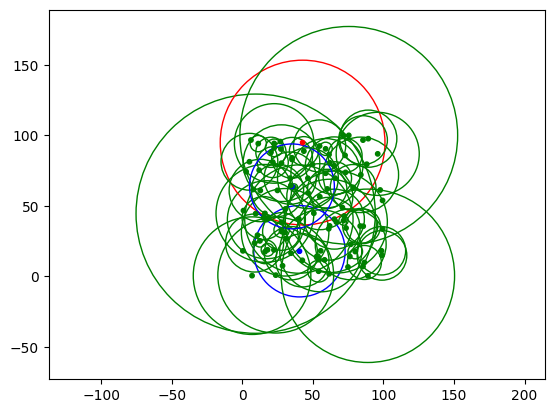

In [ ]:
import matplotlib.pyplot as plt
import math

def visualize_vp_tree(data: Dataset, tree: VpTree):
    distances = tree.distances()
    npdata = data.to_numpy()

    colors = []


    for i in range(len(data)):
        (level, d) = distances[i]
        
        # Set color based on level
        if level == 0:
            color = 'red'
        elif level == 1:
            color = 'blue'
        else:
            color = 'green'
        print(npdata[i], level, math.sqrt(d))
        colors.append(color)
        # Draw point
        # plt.scatter(pt[0], pt[1], color=color)
        
        # # Draw circle
        circle = plt.Circle((npdata[i,0], npdata[i,1]), math.sqrt(d), color=color, fill=False)
        plt.gca().add_patch(circle)
    plt.scatter(npdata[:,0], npdata[:,1], 10, colors)
    plt.axis('equal')
    plt.show()

visualize_vp_tree(data, tree)
